# CS-UY 4563 Final Project
### Chuanyang Jin, Alex(Yu) Yan  
The results are already displayed. The code for different model includes several trials and takes up too much time to run (and also we combined training & testing so there is a need to switch between the uncommented and commented part).

## File Loading

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # removing annoying warnings
import re
import seaborn as sns   
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # disable warnings

from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


# Reading in the dataset
train_df = pd.read_csv("train.csv")

## Preprocessing

We first clean up the meaningless words from the samples to reduce feature number & prevent overfitting.

In [2]:
# Clean up the text data
def clean_text(texts):
    # convert into lower letters to filter out repetition in features
    texts[:] = [text.lower() for text in texts]          

    # http:// ... / word  or  http:// ... / word                 
    texts[:] = [re.sub(r'https?:\/\/.*\/\w*', 'URL', text) for text in texts]   

    # meaningless things like mentioning a friend (e.g. @username)
    texts[:] = [re.sub(r'@\w+([-.]\w+)*', '', text) for text in texts]          

    # meaningless symbols followed by &, such as '&amp', which is a meaningless web 
    texts[:] = [re.sub(r'&\w+([-.]\w+)*', '', text) for text in texts]



clean_text(train_df['text'])



## Feature Transformation 1
Use sklearn's built in feature extraction to create a sparse martrix where every word appeared in the dataset becomes a feature.

In [51]:
# Using sklearn.feature_extraction.text.CountVectorizer()
# This converts a collection of text documents to a matrix of token counts,
# and produces a sparse representation of the counts using scipy.sparse.csr_matrix.

count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')
X_trainval = count_vectorizer.fit_transform(train_df["text"])
feature_transform = 'Token Count'

## Feature Transformation 2
Use another sklearn feature extraction method to apply tf-idf transformation to the feature vector.

In [84]:
# Using sklearn.feature_extraction.text.TfidfVectorizer()
# This converts a collection of text documents to a matrix of token counts, but adds tf-idf
# and produces a sparse representation of the counts using scipy.sparse.csr_matrix.

tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(stop_words='english')
X_trainval = tfidf_vectorizer.fit_transform(train_df["text"])
feature_transform = 'TF-IDF'

## Feature Transformation 3
We can also apply BERT pre-training to our feature to reduce feature number.

In [3]:
# Using a pre-trained BERT model
# It produces 384 features.

bert_model = SentenceTransformer('all-MiniLM-L12-v1')
X_trainval = bert_model.encode(train_df["text"])
feature_transform = 'BERT'

## Before Training
Split training set and validation set using train_test_split

In [4]:
# Split the training set into training and validation set

y_label = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_label, test_size=0.1, random_state=10)

## Method 1: Logistic Regression

In [15]:
# Fit the logistic regression model on the training set
def logistic(C, penalty, solver):
    logreg = LogisticRegression(C = C, max_iter = 100000, multi_class = 'ovr', penalty = penalty, solver = solver)
    logreg.fit(X_train, y_train)
    # Find the predicted values on the validation set

    y_hat_logreg = logreg.predict(X_val)
    # Switch between training and testing results
    # y_hat_logreg = logreg.predict(X_train)
    
    return y_hat_logreg

Conducting the logistic regression:

In [53]:
logreg_result_l1 = []
logreg_result_l2 = []
logreg_result_none = []
for C in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    for penalty in ['none','l1','l2']:
        if penalty == 'none':
            y_hat_logreg = logistic(C, penalty, solver = 'sag') # liblinear does not support no regularization
            print(f"current Iteration: C={C}, penalty: {penalty}")
            logreg_result_none.append(y_hat_logreg)
        else:
            y_hat_logreg = logistic(C, penalty, solver = 'liblinear')
            print(f"current Iteration: C={C}, penalty: {penalty}")
            if penalty == 'l1':
                logreg_result_l1.append(y_hat_logreg)
            if penalty == 'l2':
                logreg_result_l2.append(y_hat_logreg)

current Iteration: C=0.01, penalty: none
current Iteration: C=0.01, penalty: l1
current Iteration: C=0.01, penalty: l2
current Iteration: C=0.1, penalty: none
current Iteration: C=0.1, penalty: l1
current Iteration: C=0.1, penalty: l2
current Iteration: C=1, penalty: none
current Iteration: C=1, penalty: l1
current Iteration: C=1, penalty: l2
current Iteration: C=10, penalty: none
current Iteration: C=10, penalty: l1
current Iteration: C=10, penalty: l2
current Iteration: C=100, penalty: none
current Iteration: C=100, penalty: l1
current Iteration: C=100, penalty: l2
current Iteration: C=1000, penalty: none
current Iteration: C=1000, penalty: l1
current Iteration: C=1000, penalty: l2
current Iteration: C=10000, penalty: none
current Iteration: C=10000, penalty: l1
current Iteration: C=10000, penalty: l2


In [54]:
# Find Precision, recall and fscore on the validation set
f1_lr_none = []
f1_lr_l1 = []
f1_lr_l2 = []

# Testing:

for each in logreg_result_none:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_lr_none.append(fscore)
for each in logreg_result_l1:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_lr_l1.append(fscore)
for each in logreg_result_l2:
    prec, recal, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_lr_l2.append(fscore)

# Switch between training & testing results

#Training:

# for each in logreg_result_none:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_lr_none.append(fscore)
# for each in logreg_result_l1:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_lr_l1.append(fscore)
# for each in logreg_result_l2:
#     prec, recal, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_lr_l2.append(fscore)

print(f1_lr_none, f1_lr_l1, f1_lr_l2)

[0.7822222222222222, 0.7822222222222222, 0.7822222222222222, 0.7822222222222222, 0.7822222222222222, 0.7822222222222222, 0.7822222222222222] [0.0, 0.7617602427921093, 0.7909774436090226, 0.7862481315396115, 0.7833827893175074, 0.7840236686390533, 0.7822222222222222] [0.7441860465116279, 0.7896341463414633, 0.7957957957957958, 0.7868852459016393, 0.7845468053491828, 0.7840236686390533, 0.7822222222222222]


<AxesSubplot:>

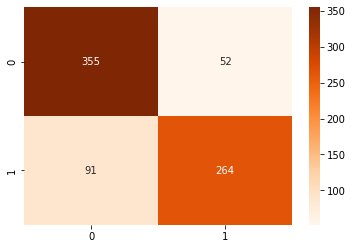

In [55]:
# Confusion Matrix -> for visualization presented in paper only

confusion_matrix_logreg = confusion_matrix(y_val, logreg_result_l2[3])
sns.heatmap(confusion_matrix_logreg, annot=True, fmt='d', cmap="Oranges")

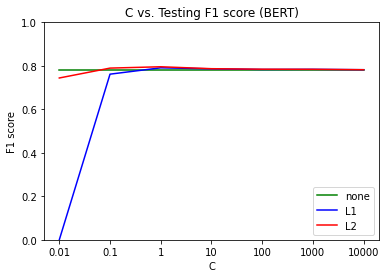

In [60]:
# Visualization of performance based on hyperparameters

# plt.title(f'C vs. Training F1 score ({feature_transform})')
plt.title(f'C vs. Testing F1 score ({feature_transform})')
plt.xlabel('C')
plt.ylabel('F1 score')
C_used = ['0.01','0.1', '1', '10', '100', '1000', '10000']
penalties = ['none','l1','l2']
plt.plot(C_used, f1_lr_none, color='g', label = 'none')
plt.plot(C_used, f1_lr_l1, color='b', label = 'L1')
plt.plot(C_used, f1_lr_l2, color='r', label = 'L2')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()


0.7969924812030075


<AxesSubplot:>

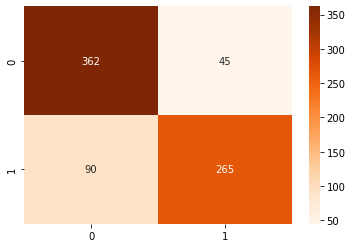

In [26]:
# y_hat_logreg = logistic(0.6, 'l2',  solver = 'liblinear')    # fscore: 0.793985
# y_hat_logreg = logistic(0.7, 'l2',  solver = 'liblinear')    # fscore: 0.795796
# y_hat_logreg = logistic(0.75, 'l2',  solver = 'liblinear')   # fscore: 0.796992   Best!
y_hat_logreg = logistic(0.8, 'l2',  solver = 'liblinear')      # fscore: 0.796992   Best!
# y_hat_logreg = logistic(0.85, 'l2',  solver = 'liblinear')   # fscore: 0.795796
# y_hat_logreg = logistic(0.9, 'l2',  solver = 'liblinear')    # fscore: 0.795796
# y_hat_logreg = logistic(1, 'l2',  solver = 'liblinear')      # fscore: 0.795796
# y_hat_logreg = logistic(1.2, 'l2',  solver = 'liblinear')    # fscore: 0.793985
# y_hat_logreg = logistic(1.4, 'l2',  solver = 'liblinear')    # fscore: 0.791541
_, _, fscore, _ = precision_recall_fscore_support(y_val, y_hat_logreg, average='binary') 
print(fscore)

confusion_matrix_logreg = confusion_matrix(y_val, y_hat_logreg)
sns.heatmap(confusion_matrix_logreg, annot=True, fmt='d', cmap="Oranges")

## Method 2: SVM

In [5]:
# Fit the SVM model on the training set
def svm(C, kernel):
    svm = SVC(C = C, kernel = kernel)
    svm.fit(X_train, y_train)
    # Find the predicted values on the validation set

    y_hat_svm = svm.predict(X_val)
    # y_hat_svm = svm.predict(X_train)

    return y_hat_svm

In [91]:
svm_result_rbf = []
svm_result_linear = []
svm_result_poly = []
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    for kernel in ['rbf','linear','poly']:
        y_hat_svm = svm(C, kernel)
        print(f"current Iteration: C={C}, kernel: {kernel}")
        if kernel == 'rbf':
            svm_result_rbf.append(y_hat_svm)
        elif kernel == 'linear':
            svm_result_linear.append(y_hat_svm)
        elif kernel == 'poly':
            svm_result_poly.append(y_hat_svm)

current Iteration: C=0.01, kernel: rbf
current Iteration: C=0.01, kernel: linear
current Iteration: C=0.01, kernel: poly
current Iteration: C=0.1, kernel: rbf
current Iteration: C=0.1, kernel: linear
current Iteration: C=0.1, kernel: poly
current Iteration: C=1, kernel: rbf
current Iteration: C=1, kernel: linear
current Iteration: C=1, kernel: poly
current Iteration: C=10, kernel: rbf
current Iteration: C=10, kernel: linear
current Iteration: C=10, kernel: poly
current Iteration: C=100, kernel: rbf
current Iteration: C=100, kernel: linear
current Iteration: C=100, kernel: poly
current Iteration: C=1000, kernel: rbf
current Iteration: C=1000, kernel: linear
current Iteration: C=1000, kernel: poly


In [92]:
# Find Precision, recall and fscore on the validation set
f1_svm_rbf = []
f1_svm_linear = []
f1_svm_poly = []


# for each in svm_result_rbf:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_svm_rbf.append(fscore)
# for each in svm_result_linear:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_svm_linear.append(fscore)
# for each in svm_result_poly:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_svm_poly.append(fscore)

# Switch between training & testing fscores

for each in svm_result_rbf:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_svm_rbf.append(fscore)
for each in svm_result_linear:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_svm_linear.append(fscore)
for each in svm_result_poly:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_svm_poly.append(fscore)


print(f1_svm_rbf, f1_svm_linear, f1_svm_poly)

[0.0, 0.19289340101522842, 0.7272727272727272, 0.7424000000000001, 0.7424000000000001, 0.7424000000000001] [0.0, 0.4745762711864407, 0.7523809523809525, 0.7333333333333334, 0.702865761689291, 0.716012084592145] [0.0, 0.1266490765171504, 0.5091649694501018, 0.5261044176706827, 0.5171717171717172, 0.4533898305084746]


<AxesSubplot:>

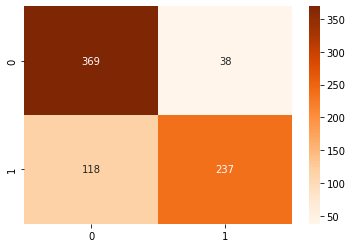

In [93]:
# Confusion Matrix

confusion_matrix_svm = confusion_matrix(y_val, svm_result_linear[2])
sns.heatmap(confusion_matrix_svm, annot=True, fmt='d', cmap="Oranges")

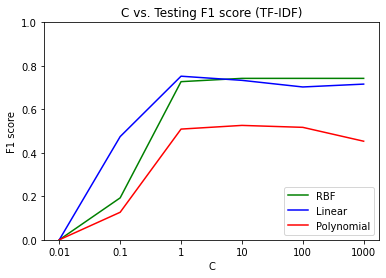

In [94]:
# Visualization of performance based on hyperparameters

plt.title(f'C vs. Testing F1 score ({feature_transform})')
# plt.title(f'C vs. Training F1 score ({feature_transform})')
plt.xlabel('C')
plt.ylabel('F1 score')
C_used = ['0.01','0.1', '1', '10', '100', '1000']
plt.plot(C_used, f1_svm_rbf, color='g', label='RBF')
plt.plot(C_used, f1_svm_linear, color='b', label='Linear')
plt.plot(C_used, f1_svm_poly, color='r', label='Polynomial')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

0.8110599078341013


<AxesSubplot:>

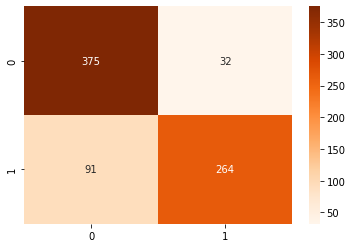

In [14]:
# y_hat_svm = svm(0.8, 'rbf')  # fscore: 0.792570
# y_hat_svm = svm(0.8, 'rbf')  # fscore: 0.8
# y_hat_svm = svm(1, 'rbf')  # fscore: 0.7987711
# y_hat_svm = svm(1.2, 'rbf')  # fscore: 0.804314
# y_hat_svm = svm(1.4, 'rbf')  # fscore: 0.807396
# y_hat_svm = svm(1.6, 'rbf')  # fscore: 0.811060    Best!
y_hat_svm = svm(1.7, 'rbf')  # fscore: 0.811060      Best!
# y_hat_svm = svm(1.8, 'rbf')  # fscore: 0.811060    Best!
# y_hat_svm = svm(2, 'rbf')  # fscore: 0.807988
# y_hat_svm = svm(3, 'rbf')  # fscore: 0.8
_, _, fscore, _ = precision_recall_fscore_support(y_val, y_hat_svm, average='binary') 
print(fscore)

confusion_matrix_svm = confusion_matrix(y_val, y_hat_svm)
sns.heatmap(confusion_matrix_svm, annot=True, fmt='d', cmap="Oranges")

## Method 3: Neural Network

In [65]:
# Fit the neural network model on the training set
def neural_network(alpha, activation, nn_structure):
    nn = MLPClassifier(hidden_layer_sizes=nn_structure, alpha = alpha, activation = activation, max_iter=10000)
    nn.fit(X_train, y_train)
    # Find the predicted values on the validation set

    y_hat_nn = nn.predict(X_val)
    # Switch between training & testing set
    # y_hat_nn = nn.predict(X_train)

    return y_hat_nn

In [66]:
nn_result_logistic = []
nn_result_relu = []
nn_result_tanh = []

nn_structure = (256, 48)
# Tuning neural network structure is omitted here for the sake of saving time
# This is the best nn_structure observed by tuning nn_structure manually

for alpha in [0.0001,0.001,0.01,0.1, 1]:
    for activation in ['logistic','relu','tanh']:
        y_hat_nn = neural_network(alpha, activation, nn_structure)
        print(f"current Iteration: alpha={alpha}, activation: {activation}")
        if activation == 'logistic':
            nn_result_logistic.append(y_hat_nn)
        if activation == 'relu':
            nn_result_relu.append(y_hat_nn)
        if activation == 'tanh':
            nn_result_tanh.append(y_hat_nn)

current Iteration: alpha=0.0001, activation: logistic
current Iteration: alpha=0.0001, activation: relu
current Iteration: alpha=0.0001, activation: tanh
current Iteration: alpha=0.001, activation: logistic
current Iteration: alpha=0.001, activation: relu
current Iteration: alpha=0.001, activation: tanh
current Iteration: alpha=0.01, activation: logistic
current Iteration: alpha=0.01, activation: relu
current Iteration: alpha=0.01, activation: tanh
current Iteration: alpha=0.1, activation: logistic
current Iteration: alpha=0.1, activation: relu
current Iteration: alpha=0.1, activation: tanh
current Iteration: alpha=1, activation: logistic
current Iteration: alpha=1, activation: relu
current Iteration: alpha=1, activation: tanh


In [16]:
f1_nn_logistic = []
f1_nn_relu = []
f1_nn_tanh = []

for each in nn_result_logistic:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_nn_logistic.append(fscore)
for each in nn_result_relu:
    _, _, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_nn_relu.append(fscore)
for each in nn_result_tanh:
    prec, recal, fscore, _ = precision_recall_fscore_support(y_val, each, average='binary')
    f1_nn_tanh.append(fscore)

# Switch between training and validation

# for each in nn_result_logistic:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_nn_logistic.append(fscore)
# for each in nn_result_relu:
#     _, _, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_nn_relu.append(fscore)
# for each in nn_result_tanh:
#     prec, recal, fscore, _ = precision_recall_fscore_support(y_train, each, average='binary')
#     f1_nn_tanh.append(fscore)


print(f1_nn_logistic, f1_nn_relu, f1_nn_tanh)


[0.7932618683001532, 0.7927382753403933, 0.7901234567901234, 0.794074074074074, 0.0] [0.7705627705627706, 0.7801204819277109, 0.7654320987654321, 0.7756315007429421, 0.8] [0.7496423462088699, 0.7341040462427746, 0.7471264367816092, 0.7621951219512195, 0.7933634992458524]


<AxesSubplot:>

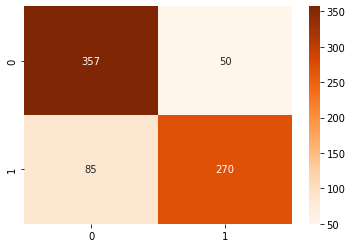

In [19]:
# Confusion Matrix

confusion_matrix_nn = confusion_matrix(y_val, nn_result_relu[4])
sns.heatmap(confusion_matrix_nn, annot=True, fmt='d', cmap="Oranges")

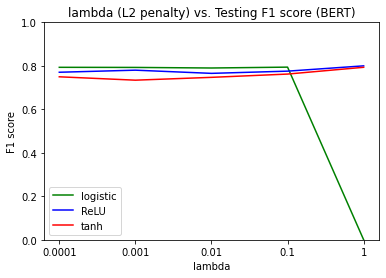

In [18]:
# Visualization of performance based on hyperparameters

plt.title(f'lambda (L2 penalty) vs. Testing F1 score ({feature_transform})')
# plt.title(f'lambda (L2 penalty) vs. Training F1 score ({feature_transform})')
plt.xlabel('lambda')
plt.ylabel('F1 score')
C_used = ['0.0001','0.001','0.01','0.1', '1']
plt.plot(C_used, f1_nn_logistic, color='g', label='logistic')
plt.plot(C_used, f1_nn_relu, color='b', label='ReLU')
plt.plot(C_used, f1_nn_tanh, color='r', label='tanh')
plt.ylim(0,1)
plt.legend(loc='lower left')
plt.show()

# Method 4: Naive Bayes

In [95]:
# Fit the naive_bayes model on the training set
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
# nb = BernoulliNB(alpha=0.1)     # fscore:  0.7891737891737892
nb = BernoulliNB(alpha=1)         # fscore:  0.7891737891737892
# nb = BernoulliNB(alpha=10)      # fscore:  0.7891737891737892

# nb = BernoulliNB(binarize=0.001)         # fscore:  0.7857142857142857
# nb = BernoulliNB(binarize=0.0001)         # fscore:  0.7874465049928673

# nb = BernoulliNB(fit_prior=False)         # fscore:  0.788135593220339


# nb = GaussianNB()         # fscore:  0.7839771101573677
# nb = CategoricalNB()      # fscore: 0.0
# nb = ComplementNB()       # cannot deal with negative values
# nb = MultinomialNB()      # cannot deal with negative values

nb.fit(X_train, y_train)       
# Find the predicted values on the validation set
y_hat_nb = nb.predict(X_val)

prec:  0.7982708933717579
recal:  0.780281690140845
fscore:  0.7891737891737892


<AxesSubplot:>

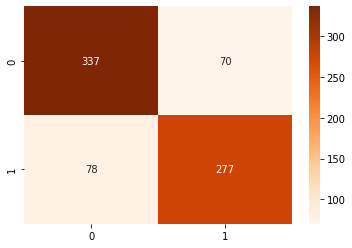

In [96]:
# Find Precision, recall and fscore on the validation set
from sklearn.metrics import precision_recall_fscore_support
prec, recal, fscore, _ = precision_recall_fscore_support(y_val, y_hat_nb,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

# Confusion Matrix
confusion_matrix_nb = confusion_matrix(y_val, y_hat_nb)
sns.heatmap(confusion_matrix_nb, annot=True, fmt='d', cmap="Oranges")

# Method 5: Random Forest

In [61]:
# Fit the random forest model on the training set
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of trees
# rf = RandomForestClassifier(n_estimators=10)        # fscore:  0.6885245901639344
# rf = RandomForestClassifier(n_estimators=50)        # fscore:  0.7576243980738362
# rf = RandomForestClassifier(n_estimators=90)        # fscore:  0.770440
rf = RandomForestClassifier(n_estimators=100)         # fscore:  0.7868338557993729
# rf = RandomForestClassifier(n_estimators=110)       # fscore:  0.7641509433962265
# rf = RandomForestClassifier(n_estimators=200)       # fscore:  0.7670364500792393
# rf = RandomForestClassifier(n_estimators=1000)      # fscore:  0.7733755942947703
rf.fit(X_train, y_train)
# Find the predicted values on the validation set
y_hat_rf = rf.predict(X_val)

prec:  0.8811188811188811
recal:  0.7098591549295775
fscore:  0.7862714508580344


<AxesSubplot:>

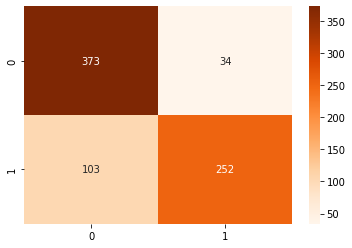

In [62]:
# Find Precision, recall and fscore on the validation set
from sklearn.metrics import precision_recall_fscore_support
prec, recal, fscore, _ = precision_recall_fscore_support(y_val, y_hat_rf,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

# Confusion Matrix
confusion_matrix_rf = confusion_matrix(y_val, y_hat_rf)
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap="Oranges")

# Method 6: Gradient Boosting

In [102]:
# Fit the gradient boosting model on the training set
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)      # fscore: 0.7914110429447853
# gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=99)      # fscore: 0.7914110429447853
# gb = GradientBoostingClassifier(learning_rate=0.08, n_estimators=125)   # fscore:  0.7870370370370371
# gb = GradientBoostingClassifier(learning_rate=1.1, n_estimators=90)     # fscore:  0.7478260869565216
gb.fit(X_train, y_train)
# Find the predicted values on the validation set
y_hat_gb = gb.predict(X_val)

prec:  0.8686868686868687
recal:  0.7267605633802817
fscore:  0.7914110429447853


<AxesSubplot:>

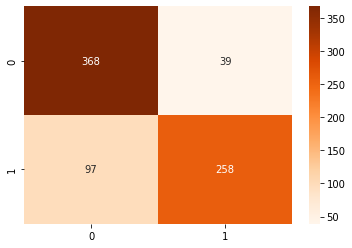

In [104]:
# Find Precision, recall and fscore on the validation set
from sklearn.metrics import precision_recall_fscore_support
prec, recal, fscore, _ = precision_recall_fscore_support(y_val, y_hat_gb,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

# Confusion Matrix
confusion_matrix_gb = confusion_matrix(y_val, y_hat_gb)
sns.heatmap(confusion_matrix_gb, annot=True, fmt='d', cmap="Oranges")

fscore:  0.7969924812030075
fscore:  0.8110599078341013
fscore:  0.8023255813953489
fscore:  0.8035714285714287
fscore:  0.8025276461295419
fscore:  0.812121212121212


<AxesSubplot:>

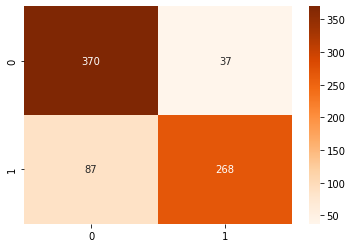

In [119]:
y_hat_1 = y_hat_logreg
y_hat_2 = y_hat_svm
y_hat_3 = nn_result_relu[4]
_, _, fscore1, _ = precision_recall_fscore_support(y_val, y_hat_1,average='binary')
print('fscore: ', fscore1)
_, _, fscore2, _ = precision_recall_fscore_support(y_val, y_hat_2,average='binary')
print('fscore: ', fscore2)
_, _, fscore3, _ = precision_recall_fscore_support(y_val, y_hat_3,average='binary')
print('fscore: ', fscore3)

y_hat_4 = []
for i in range(len(y_hat_logreg)):
    y_hat_4.append((y_hat_1[i]+(y_hat_2[i]+(y_hat_3[i]))) // 2)
_, _, fscore4, _ = precision_recall_fscore_support(y_val, y_hat_4,average='binary')
print('fscore: ', fscore4)

y_hat_5 = []
for i in range(len(y_hat_logreg)):
    y_hat_5.append((y_hat_1[i]+(y_hat_2[i]+(y_hat_3[i]))) // 3)
_, _, fscore5, _ = precision_recall_fscore_support(y_val, y_hat_5,average='binary')
print('fscore: ', fscore5)

# Highest fscore method!!!!!
y_hat_gb
y_hat_6 = []
for i in range(len(y_hat_logreg)):
    if (y_hat_1[i] == y_hat_3[i]) and (y_hat_3[i] == y_hat_gb[i]):
        y_hat_6.append(y_hat_1[i])
    else:
        y_hat_6.append(y_hat_2[i])
_, _, fscore6, _ = precision_recall_fscore_support(y_val, y_hat_6,average='binary')
print('fscore: ', fscore6)

# Confusion Matrix
confusion_matrix_6 = confusion_matrix(y_val, y_hat_6)
sns.heatmap(confusion_matrix_6, annot=True, fmt='d', cmap="Oranges")